# Classification: predicting client attrition

### Loading required libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score #for hyperparameters tuning
#%pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import numpy as np

%pip install optuna
#cross validation:
import optuna
import logging
import sys
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

Note: you may need to restart the kernel to use updated packages.


/Users/mac/anaconda3/envs/ml-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train Data

In [9]:
train_org = pd.read_csv('client_attrition_train.csv')
train_org.dtypes
train_org.shape

(10127, 21)

## EDA + Preprocessing

### Dropping customer id

In [10]:
train_org['account_status'].value_counts()

#dropping customer id
train_org.drop("customer_id", inplace = True, axis = 1)
#severe class imbalance! (we will adress this problem later with SMOTE)

In [11]:
#inspecting na values
train_org.isna().sum()

customer_age                        624
customer_sex                       1018
customer_number_of_dependents         0
customer_education                    0
customer_civil_status                 0
customer_salary_range               681
customer_relationship_length          0
customer_available_credit_limit       0
credit_card_classification            0
total_products                        0
period_inactive                       0
contacts_in_last_year                 0
credit_card_debt_balance              0
remaining_credit_limit                0
transaction_amount_ratio              0
total_transaction_amount            407
total_transaction_count               0
transaction_count_ratio               0
average_utilization                   0
account_status                        0
dtype: int64

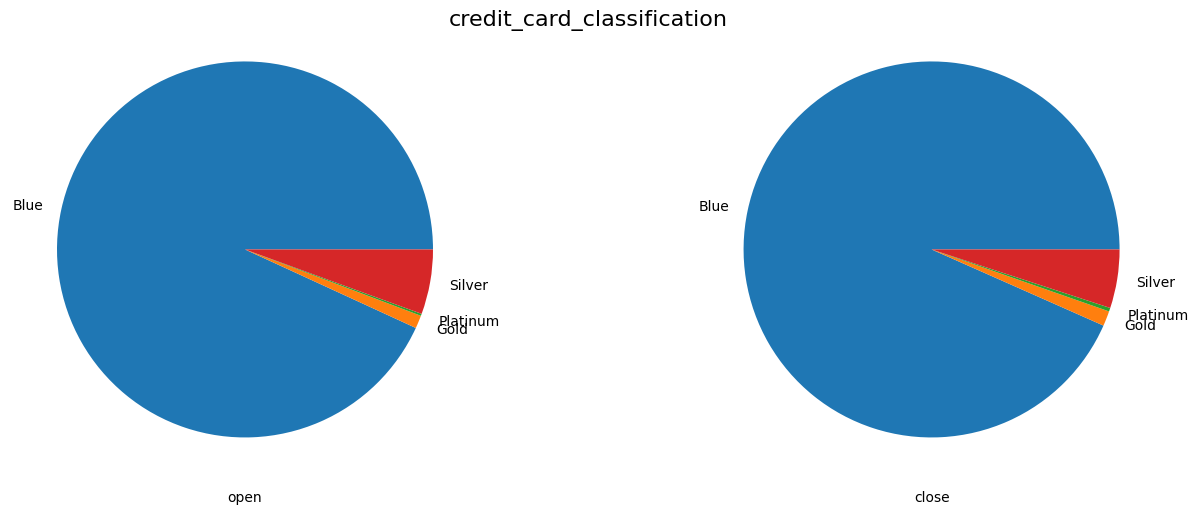

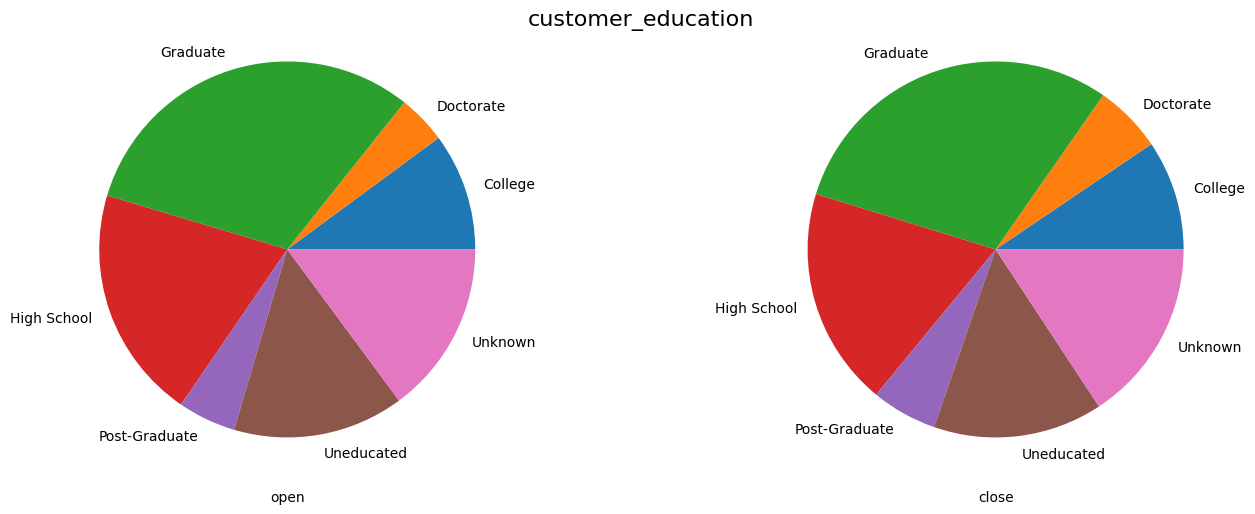

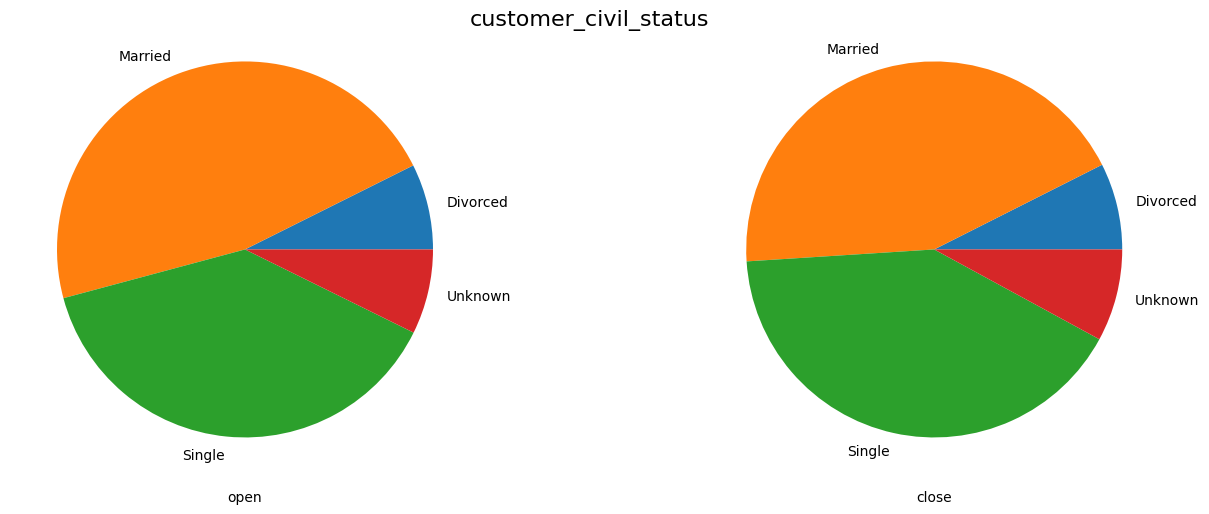

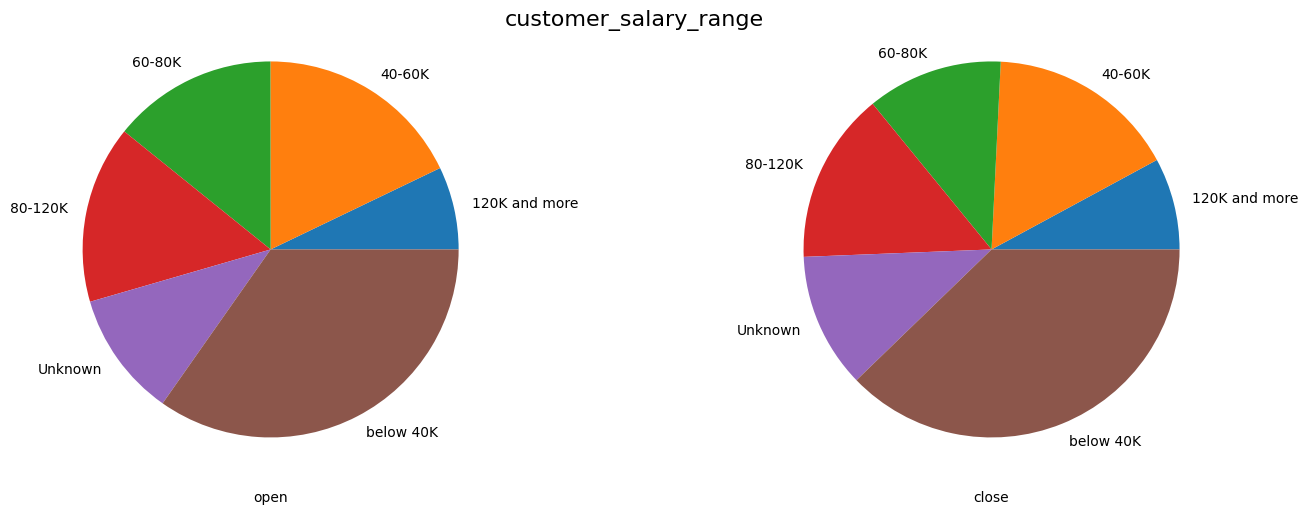

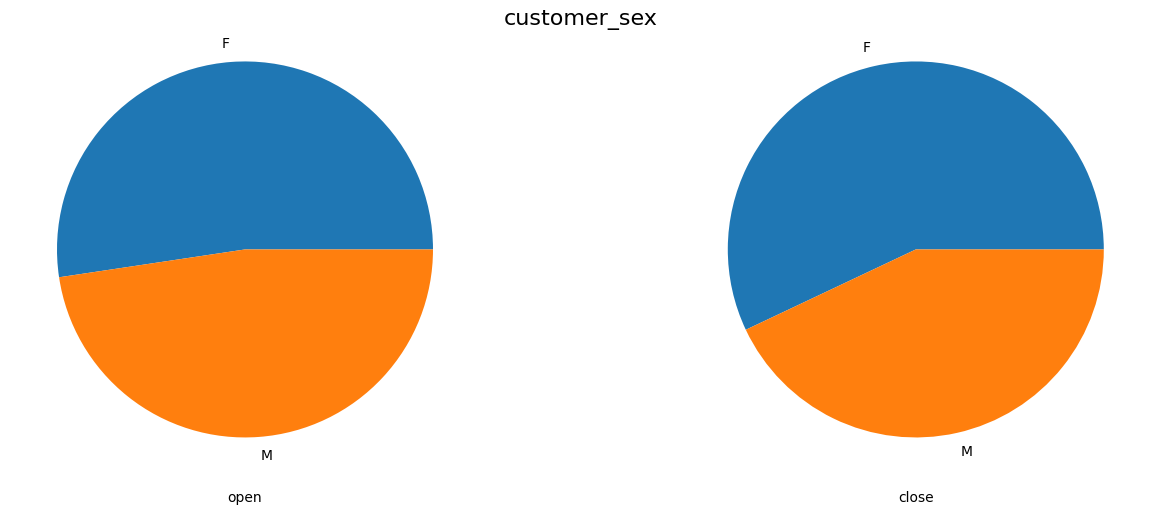

In [12]:
#categorical vars distributions 
for cat in ["credit_card_classification", "customer_education", "customer_civil_status", "customer_salary_range", "customer_sex"]:

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    train_org.loc[train_org["account_status"]=="open", cat].reset_index().groupby(cat).size().plot(kind="pie", ax=ax1)
    train_org.loc[train_org["account_status"]=="closed", cat].reset_index().groupby(cat).size().plot(kind="pie", ax=ax2)
    fig.tight_layout()
    ax1.set_xlabel("open")
    ax2.set_xlabel("close")
    fig.suptitle(cat, fontsize=16)
    


## Data Imputation with ExtraTrees

In [13]:
#replacing unknown with nans where applicable 
train_org.loc[train_org['customer_salary_range']=='Unknown', 'customer_salary_range'] = np.nan
train_org.loc[train_org['customer_civil_status']=='Unknown', 'customer_civil_status'] = np.nan
train_org.loc[train_org['customer_education']=='Unknown', 'customer_education'] = np.nan

lb = LabelBinarizer()

#encoding ordinals as ordinals
#function for encoding ordinal variables
def encode(data, order=[]):
    '''function to encode non-null data and replace it in the original data'''
    encoder = LabelEncoder()
    
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    encoder.fit(order)
    impute_ordinal = encoder.transform(impute_reshape)
    
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

# Fit and transform status & customer_sex to binary variable
train_org['account_status'] = lb.fit_transform(train_org['account_status'])
train_org['customer_sex'] = train_org['customer_sex'].astype(str)
train_org['customer_sex'] = lb.fit_transform(train_org['customer_sex'])


#changing type for ordinal vars
train_org['customer_salary_range'] = train_org['customer_salary_range'].astype(object)
train_org['customer_civil_status'] = train_org['customer_civil_status'].astype(object)
train_org['customer_education'] = train_org['customer_education'].astype(object)
train_org['credit_card_classification'] = train_org['credit_card_classification'].astype(object)

#create a for loop to iterate through each column with ordinal var in the data
train_org['customer_salary_range'] = encode(train_org['customer_salary_range'], order = ["below 40K","40-60K","80-120K","60-80K","120K and more"])
train_org['customer_education'] = encode(train_org['customer_education'], order = ["High School", "Uneducated", "College", "Graduate", "Post-Graduate", "Doctorate"]) 
train_org['credit_card_classification'] = encode(train_org['credit_card_classification'], order = ["Blue", "Silver", "Gold", "Platinum"]) 


#dummies
for col in ['customer_civil_status']: 
    dummies = pd.get_dummies(train_org[col])

    # Add dummy variables to the original DataFrame, leaving NaNs untouched
    train_org = pd.concat([train_org, dummies], axis=1)
    train_org.drop([col], axis=1, inplace=True)

#instantiate imputer (there are two listed as the best" ExtraTrees and BayesianRidge I am opting for te first one)
imputer = IterativeImputer(ExtraTreesRegressor(n_estimators=20, random_state=0))

columns = train_org.columns

#impute data and convert 
train_org = pd.DataFrame(np.round(imputer.fit_transform(train_org)), columns = columns)

/Users/mac/anaconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/var/folders/qb/z1cbz14x723cj5l8lxt1k2f00000gn/T/ipykernel_43507/1837769977.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data.notnull()] = np.squeeze(impute_ordinal)
/Users/mac/anaconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Distribution of Variables

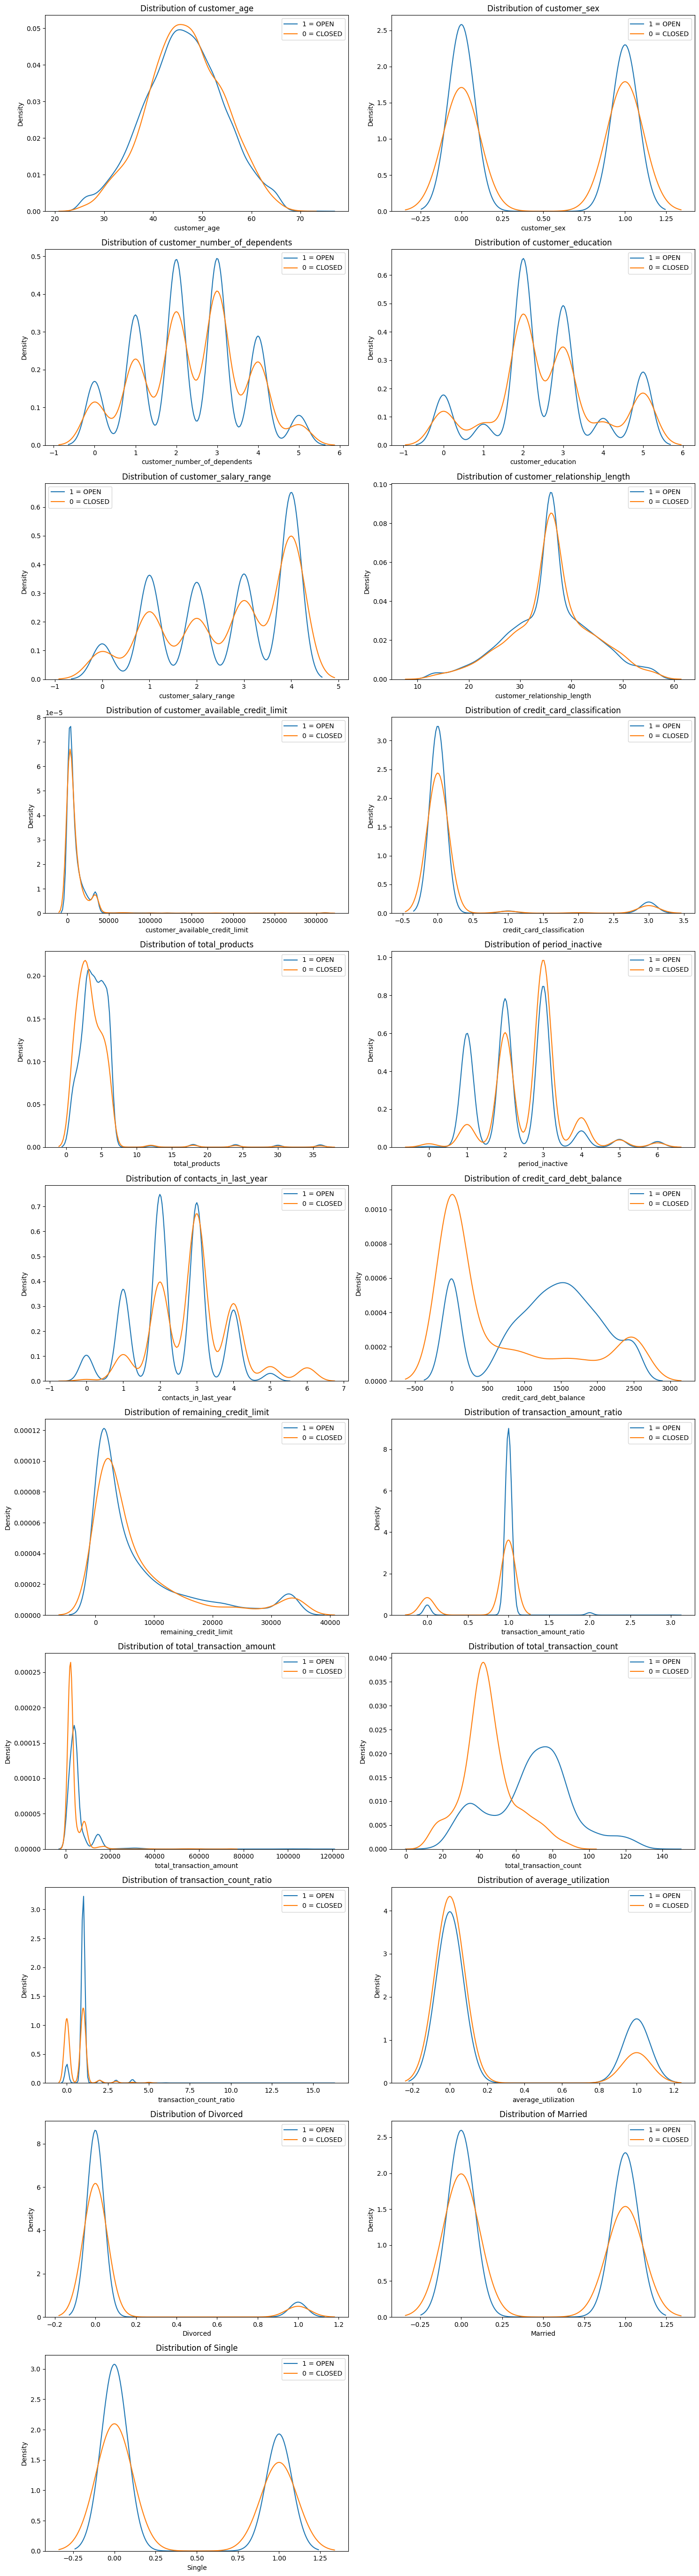

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

numeric_part_of_train_org = train_org.select_dtypes(['number'])
columns = numeric_part_of_train_org.columns.drop("account_status")

# Calculate the number of rows needed in the grid
nrows = len(columns) // 2 + len(columns) % 2

# Create the subplots grid
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))

# Flatten the grid for looping through subplots
axes = axes.flatten()

# Loop through the numerical columns and plot the density plots in each subplot
for i, column in enumerate(columns):
    sns.distplot(train_org.loc[train_org["account_status"]==1, column], hist=False, label="1 = OPEN", ax=axes[i])
    sns.distplot(train_org.loc[train_org["account_status"]==0, column], hist=False, label="0 = CLOSED", ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].set_title("Distribution of " + column)
    axes[i].legend()
    
# Remove the empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()


## Clipping last two percentiles in case of outliers

In [15]:
#CLIPPING
cutoff_transaction_count_ratio = train_org.transaction_count_ratio.quantile(0.98)
cutoff_total_transaction_amount = train_org.total_transaction_amount.quantile(0.98)
cutoff_transaction_amount_ratio = train_org.transaction_amount_ratio.quantile(0.98)
cutoff_customer_available_credit_limit = train_org.customer_available_credit_limit.quantile(0.98)

train_org["transaction_count_ratio"] = train_org.transaction_count_ratio.clip(upper=cutoff_transaction_count_ratio)
train_org["total_transaction_amount"] = train_org.total_transaction_amount.clip(upper=cutoff_total_transaction_amount)
train_org["transaction_amount_ratio"] = train_org.transaction_amount_ratio.clip(upper=cutoff_transaction_amount_ratio)
train_org["customer_available_credit_limit"] = train_org.customer_available_credit_limit.clip(upper=cutoff_customer_available_credit_limit)

## Correlogram

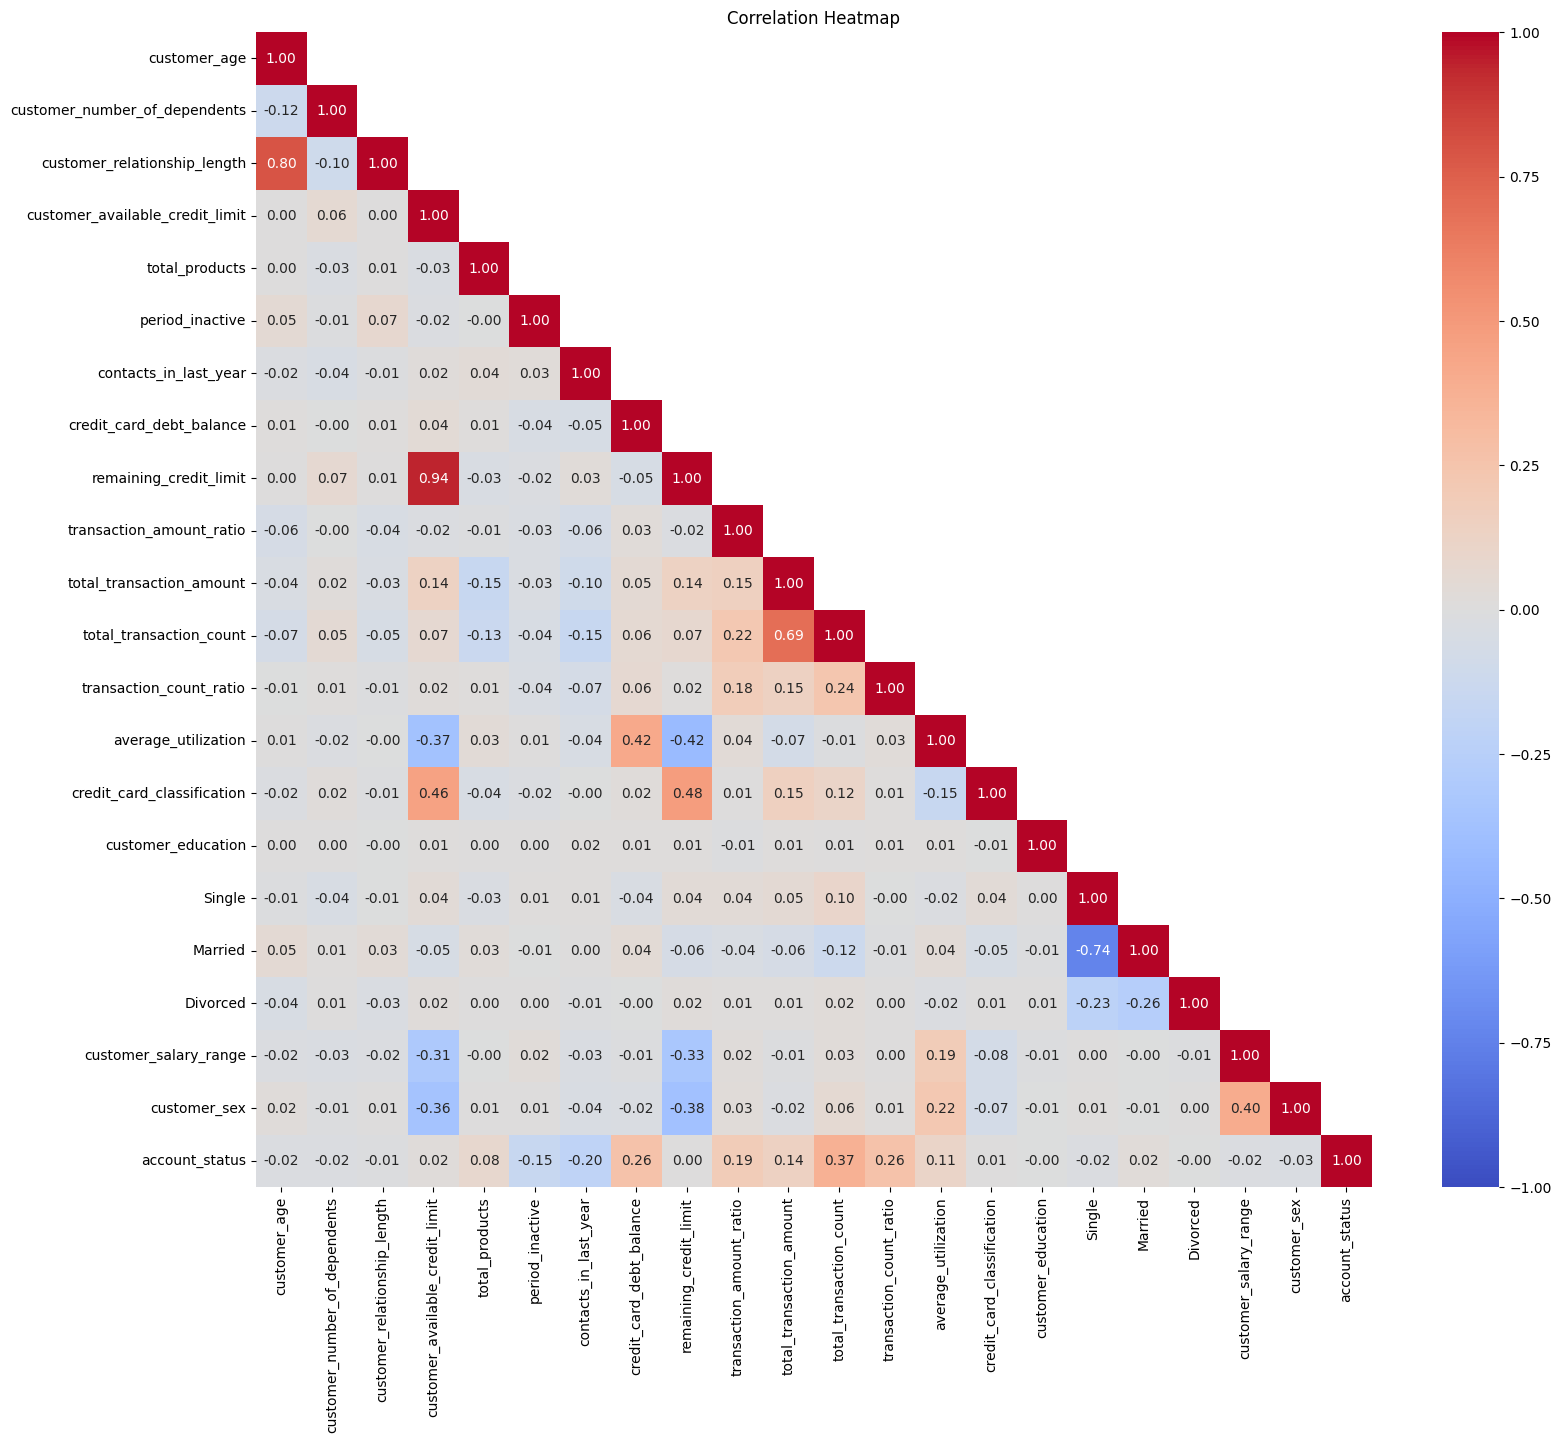

In [16]:

train_org_selected = train_org[['customer_age', 'customer_number_of_dependents',
       'customer_relationship_length', 'customer_available_credit_limit',
       'total_products', 'period_inactive', 'contacts_in_last_year',
       'credit_card_debt_balance', 'remaining_credit_limit',
       'transaction_amount_ratio', 'total_transaction_amount',
       'total_transaction_count', 'transaction_count_ratio',
       'average_utilization',"credit_card_classification", "customer_education",
                  "Single", "Married", "Divorced", "customer_salary_range", "customer_sex", 'account_status']]

corr = train_org_selected.corr()

# Create a boolean mask for the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

plt.figure(figsize=(18,15))
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1.0, cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
## Anova

In [18]:
# ANALYSIS OF VARIANCE INBETWEEN VARIABLES
from scipy import stats

# Create an empty DataFrame to store ANOVA results
anova_results = pd.DataFrame(columns=train_org.columns)

# Perform ANOVA for each pair of variables
for column in train_org.loc[:, train_org.columns != 'account_status']:  # Exclude the target variable
    fvalue, pvalue = stats.f_oneway(train_org[column][train_org['account_status'] == 0], train_org[column][test_org['account_status'] == 1])
    anova_results.loc['F-value', column] = fvalue
    anova_results.loc['p-value', column] = pvalue

# Display the ANOVA results table
anova_results.T

# interpretation: a low p-value suggests that there is strong evidence against the null hypothesis 
# and indicates a significant difference between the groups being compared.

,F-value,p-value
customer_age,3.650561,0.056079
customer_sex,8.796682,0.003025
customer_number_of_dependents,3.652825,0.056002
customer_education,0.000226,0.988013
customer_salary_range,3.509922,0.061031
customer_relationship_length,1.897071,0.168437
customer_available_credit_limit,5.230274,0.022218
credit_card_classification,0.369161,0.543475
total_products,64.478363,0.0
period_inactive,240.910376,0.0


### Scaling training data

In [29]:
#Y and X set
y_train=test_org["account_status"].values
x_train=test_org.drop("account_status", axis = 1).values

In [31]:
from sklearn.preprocessing import MinMaxScaler

#Scale the data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)


## Test Data 
- Test data needs to undergo exactly the same transformations as did the train set

In [22]:
test_org = pd.read_csv('client_attrition_test.csv')
test_org.dtypes
test_org.shape

(5063, 20)

### Dropping customer id

In [ ]:
test_org['account_status'].value_counts()

#dropping customer id
test_org.drop("customer_id", inplace = True, axis = 1)
#severe class imbalance! (we will adress this problem later with SMOTE)

### Data Imputation with ExtraTrees

- encoding and imputing are done with imputer/encoder fitted on train data

In [ ]:
#replacing unknown with nans where applicable 
test_org.loc[test_org['customer_salary_range']=='Unknown', 'customer_salary_range'] = np.nan
test_org.loc[test_org['customer_civil_status']=='Unknown', 'customer_civil_status'] = np.nan
test_org.loc[test_org['customer_education']=='Unknown', 'customer_education'] = np.nan

# Fit and transform status & customer_sex to binary variable
test_org['account_status'] = lb.fit_transform(test_org['account_status'])
test_org['customer_sex'] = test_org['customer_sex'].astype(str)
test_org['customer_sex'] = lb.fit_transform(test_org['customer_sex'])


#changing type for ordinal vars
test_org['customer_salary_range'] = test_org['customer_salary_range'].astype(object)
test_org['customer_civil_status'] = train_org['customer_civil_status'].astype(object)
test_org['customer_education'] = train_org['customer_education'].astype(object)
test_org['credit_card_classification'] = test_org['credit_card_classification'].astype(object)

#create a for loop to iterate through each column with ordinal var in the data
test_org['customer_salary_range'] = encode(test_org['customer_salary_range'], order = ["below 40K","40-60K","80-120K","60-80K","120K and more"])
test_org['customer_education'] = encode(train_org['customer_education'], order = ["High School", "Uneducated", "College", "Graduate", "Post-Graduate", "Doctorate"]) 
test_org['credit_card_classification'] = encode(train_org['credit_card_classification'], order = ["Blue", "Silver", "Gold", "Platinum"]) 


#dummies
for col in ['customer_civil_status']: 
    dummies = pd.get_dummies(test_org[col])

    # Add dummy variables to the original DataFrame, leaving NaNs untouched
    test_org = pd.concat([train_org, dummies], axis=1)
    train_org.drop([col], axis=1, inplace=True)

columns = train_org.columns

#impute data and convert 
train_org = pd.DataFrame(np.round(imputer.fit_transform(train_org)), columns = columns)

### Clipping last two percentiles in case of outliers

In [ ]:
#CLIPPING
cutoff_transaction_count_ratio = train_org.transaction_count_ratio.quantile(0.98)
cutoff_total_transaction_amount = train_org.total_transaction_amount.quantile(0.98)
cutoff_transaction_amount_ratio = train_org.transaction_amount_ratio.quantile(0.98)
cutoff_customer_available_credit_limit = train_org.customer_available_credit_limit.quantile(0.98)

train_org["transaction_count_ratio"] = train_org.transaction_count_ratio.clip(upper=cutoff_transaction_count_ratio)
train_org["total_transaction_amount"] = train_org.total_transaction_amount.clip(upper=cutoff_total_transaction_amount)
train_org["transaction_amount_ratio"] = train_org.transaction_amount_ratio.clip(upper=cutoff_transaction_amount_ratio)
test_org["customer_available_credit_limit"] = test_org.customer_available_credit_limit.clip(upper=cutoff_customer_available_credit_limit)

### Scaling test data

In [ ]:
#X test set
x_test=test_org.drop("account_status", axis = 1).values
x_test = sc.fit_transform(x_test)

## Training and Estimating best of considered models 
In classification problem two approaches to model performance validation proved useful:
1. Stratified 5-fold cross-validation with optuna package on entire train set (stratification accounted for classes imbalance)
2. Choosing the best probability threshold under assumption that any improvements
on the randomly selected test set will transfer onto  entire dataset. 

After applying these to:

- Logistic regression
- SVM based classifier
- Random trees classifier
- Ensemble model: XGBoost classifier

the last proved to be the best in case of all considered metrics (balanced_accuracy, average_precision, ROC_AUC_score)


In [62]:
#Training XGBoost
from xgboost import XGBClassifier

#model with best selected parameters for balanced_accuracy
xgb = XGBClassifier(**{'learning_rate': 0.15465980652073305, 'gamma': 0.3404512347916525,
                       'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7478402887506124,
                       'colsample_bytree': 0.9939935327555298, 'reg_alpha': 2.5158754623380393,
                       'reg_lambda': 1.1434967083772378, 'n_estimators': 151})

xgb.fit(x_train, y_train)

#Generating predictions with custom, optimised thresholding
y_pred_proba = xgb.predict_proba(x_test)[:, 1]
threshold = 0.62
y_pred = (y_pred_proba >= threshold).astype(int)